In [63]:
# this file is for running the line-fitting models and plot the best-fitting results 
import numpy as np
from astropy.io import fits
import os, sys
# from veremisfitting.line_fitting_exec import *
# from veremisfitting.line_fitting_model import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models,fitting
from scipy import interpolate

%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

import astropy.io.fits as pyfits
import astropy.units as u

import sep
import glob
import grizli
from grizli import utils
print(f'grizli version: {grizli.__version__}')

import msaexp
import msaexp.spectrum
print(f'msaexp version: {msaexp.__version__}')

from astropy.table import Table
import astropy.units as u
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib.gridspec import GridSpec
from astropy.cosmology import FlatLambdaCDM
import matplotlib.ticker as ticker
cosmo = FlatLambdaCDM(70 * (u.km/u.s/u.Mpc), 0.3)

import astropy.units as u
import astropy.constants as c
import matplotlib.cm as cm
cmap = cm.get_cmap('rainbow')
plt.style.use('/Users/zijianzhang/Astro_Data/paper.mplstyle')


BASE_URL = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
PATH_TO_FILE = BASE_URL + '{root}/{file}'
# define the absolute path of the current working directory
current_direc = os.getcwd() 

def read_results_from_txt(filename):
    """
    Read flux, EW, FWHM results with errors, Gaussian parameters, and Chi-squared values from a text file.

    Parameters:
    - filename: Path to the input text file.
    
    Returns:
    - A dictionary containing all the extracted parameters, including Gaussian parameters and their errors.
    """
    results = {}

    with open(filename, 'r') as f:
        lines = f.readlines()

    # Extract source ID
    results['source_id'] = lines[0].split(":")[1].strip()

    # Find the number of Gaussian components
    for line in lines:
        if line.startswith("Number of Gaussian Components"):
            results['num_gaussians'] = int(line.split(":")[1].strip())
            break
    
    # Extract Gaussian components parameters and errors
    gaussians = []
    current_gaussian = None
    for line in lines:
        if line.startswith("Gaussian"):
            if current_gaussian is not None:
                gaussians.append(current_gaussian)
            current_gaussian = {}
        if line.startswith("  Amplitude"):
            current_gaussian['Amplitude'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Amplitude_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Mean (Velocity)"):
            current_gaussian['Mean'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Mean_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Stddev (Width)"):
            current_gaussian['Stddev'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Stddev_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("-" * 40):  # End of a Gaussian block
            if current_gaussian is not None:
                gaussians.append(current_gaussian)
                current_gaussian = None

    # remove empty gaussians
    gaussians = [g for g in gaussians if g]
    results['gaussians'] = gaussians
    

    # Extract component results (Flux, EW, FWHM)
    components = []
    current_component = None
    for line in lines:
        if line.startswith("Gaussian"):
            if current_component is not None:
                components.append(current_component)
            current_component = {}
        if line.startswith("  Flux"):
            current_component['Flux'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['Flux_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  EW"):
            current_component['EW'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['EW_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  FWHM"):
            current_component['FWHM'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['FWHM_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Luminosity"): 
            current_component['Luminosity'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['Luminosity_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("-" * 40):  # End of a component block
            if current_component is not None:
                components.append(current_component)
                current_component = None

    # remove empty components
    components = [c for c in components if c]
    results['components'] = components

    # Extract Chi-squared and Reduced Chi-squared values
    for line in lines:
        if line.startswith("Chi-squared"):
            results['chi2'] = float(line.split(":")[1].strip())
        elif line.startswith("Reduced Chi-squared"):
            results['reduced_chi2'] = float(line.split(":")[1].strip())

    return results

def read_filter_data(filename):
    data = np.loadtxt(filename, skiprows=1)
    wavelength = data[:, 0]
    throughput = data[:, 1]
    return wavelength, throughput

def lam_mean(lam, trans):
    if not len(lam) == len(trans):
        return 'wrong'
    sum1 = 0; sum2 = 0
    for i in range(len(lam)-1):
        sum1 += lam[i] * trans[i] * (lam[i+1] - lam[i])
        sum2 += trans[i] * (lam[i+1] - lam[i])
    return sum1/sum2

def clc_lam_pivot(wave, trans):
    f1 = InterpolatedUnivariateSpline(wave, trans, k=1) 
    f2 = InterpolatedUnivariateSpline(wave, trans/wave**2, k=1) 
    lam_pivot =  (f1.integral(min(wave), max(wave)) / f2.integral(min(wave), max(wave)))**0.5
    return lam_pivot


Duplicate key in file '/Users/zijianzhang/Astro_Data/paper.mplstyle', line 23 ('axes.linewidth : 1.5')


grizli version: 1.12.9
msaexp version: 0.9.2


In [ ]:
# 使用样条插值计算 rest-frame NUV 和 FUV（假设 NUV 是 2310 Å，FUV 是 1530 Å）
rest_NUV = 2310  # NUV 波长 (单位: Å)
rest_FUV = 1530  # FUV 波长 (单位: Å)   

Hz_NUV = (const.c / (rest_NUV * u.AA)).to(u.Hz)
Hz_FUV = (const.c / (rest_FUV * u.AA)).to(u.Hz)
# 计算 NUV 和 FUV 的光度（erg/s/Hz）
F_NUV = spline(rest_NUV)*u.erg / (u.s * u.Hz * u.cm**2)
F_FUV = spline(rest_FUV)*u.erg / (u.s * u.Hz * u.cm**2)    
lumi_dist = cosmo.luminosity_distance(redshift).to(u.cm)
L_NUV = (4 * np.pi * lumi_dist**2 * F_NUV * Hz_NUV).to(u.erg/u.s).value
L_FUV = (4 * np.pi * lumi_dist**2 * F_FUV * Hz_FUV).to(u.erg/u.s).value
# 显示结果
# print(f"Slope: {slope:.3e}, Intercept: {intercept:.3e}")
print(f"Rest-frame NUV flux: {L_NUV:.3e} erg/s")
print(f"Rest-frame FUV flux: {L_FUV:.3e} erg/s") 

In [83]:
lrd_spec_info = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_lsf_z2/LRD_spectral_catalog.csv')
source_id = lrd_spec_info['source_id']

In [91]:
def get_UV_luminosity(ID, results_path, fig_save_path):
    f = fits.open(results_path + '/%d_best_model.fits'%ID)
    z = float(f[1].header['universe.redshift'])
    
    NUV_wave_obs = 0.2310*(1+z)*u.um
    FUV_wave_obs = 0.1530*(1+z)*u.um
    NUV_freq_obs = (c.c / NUV_wave_obs).to(u.Hz)
    FUV_freq_obs = (c.c / FUV_wave_obs).to(u.Hz)
    DL = cosmo.luminosity_distance(z)
    
    data_mod = f[1].data
    wave_mod = data_mod['wavelength']*1e-3# micro meter
    flux_mod = data_mod['Fnu']
    f_obs = fits.open(results_path + '/observations.fits')
    data_obs = f_obs[1].data
    f_mod_band = fits.open(results_path + '/results.fits')

    data_mod_band = f_mod_band[1].data
    q = np.where(data_mod_band['id']==ID)[0][0]

    band_lam = []; band_flux = []
    data_obs_bands = data_obs.names[2::2]  #data_obs.names[2:25]
    obsy = np.array(list(data_obs[q][2::2]))
    obsyerr = np.array(list(data_obs[q][3::2]))
    data_obs_bands = np.array(data_obs_bands)
    mask = obsyerr > 0



    obsy = np.array(list(data_obs[q][2::2]))
    obsyerr = np.array(list(data_obs[q][3::2]))
    data_obs_bands = np.array(data_obs_bands)
    mask = obsyerr > 0
    data_obs_bands = data_obs_bands[mask]
    colors = [cmap(i) for i in np.linspace(0, 1, len(data_obs_bands))]
    for j in range(len(data_obs_bands)):
        band = data_obs_bands[j]
        band_tran = band.split('.')[-1]
        file = '/Users/zijianzhang/Astro_Data/LRD_SPEC/nircam_throughputs/mean_throughputs/' + band_tran.upper() + '_throughput.txt'
        wave, trans = read_filter_data(file)
        wave = np.array(wave)*1e-4; trans = np.array(trans)
        wave_pivot = clc_lam_pivot(wave, trans)
        band_lam.append(wave_pivot)
        band_flux.append(data_mod_band['best.'+band][q] )



    colors = [cmap(i) for i in np.linspace(0, 1, len(data_obs_bands))]
    data_tot = data_mod['stellar.old'] + data_mod['stellar.young'] + data_mod['nebular.emission_old'] + data_mod['nebular.emission_young']
    # data_AGN = data_mod['agn.SKIRTOR2016_torus'] + data_mod['agn.SKIRTOR2016_polar_dust'] + data_mod['agn.SKIRTOR2016_disk']
    attenuated_stellar = data_mod['stellar.young'] + data_mod['attenuation.stellar.young'] + data_mod['nebular.absorption_young'] + data_mod['stellar.old'] + data_mod['attenuation.stellar.old'] + data_mod['nebular.absorption_old']
    data_tot = (data_tot * u.W/u.nm / DL**2 * (wave_mod*u.um)**2 / c.c).to(u.mJy) / 13.267335
    # data_AGN = (data_AGN * u.W/u.nm / DL**2 * (wave_mod*u.um)**2 / c.c).to(u.mJy) / 13.267335
    attenuated_stellar = (attenuated_stellar * u.W/u.nm / DL**2 * (wave_mod*u.um)**2 / c.c).to(u.mJy) / 13.267335


    plt.scatter( np.log10(band_lam), band_flux, color = 'red', s = 30, zorder=9, label='Model')
    # plt.errorbar(np.log10(band_lam), obsy[mask], yerr = obsyerr[mask], 
    #                  ms=8, color = 'purple', fmt = 'o', markerfacecolor=(0, 0, 0, 0),
    #                  markeredgecolor='purple', zorder=10, label='Observed')
    plt.plot(np.log10(wave_mod),data_tot, color = '#1075F8', lw = 1.3, zorder=5 , ls = '--', label = 'Unattenuated stellar and nebular')
    plt.plot(np.log10(wave_mod),attenuated_stellar, color = '#FFD707', lw = 1.3, zorder=5, label = 'Attenuated stellar')
    # plt.plot(np.log10(wave_mod),data_AGN, color = '#FFB677', lw = 1.3, zorder=5, label = 'AGN emission')
    plt.plot(np.log10(wave_mod), flux_mod, color = 'k', lw = 1.3, zorder=6, label='Model Spectrum')
    plt.axvline(np.log10(NUV_wave_obs.value), color = 'k', lw = 1.3, ls = '--')
    plt.axvline(np.log10(FUV_wave_obs.value), color = 'k', lw = 1.3, ls = '--')
    # plt.xlim(np.log10(0.7), np.log10(5.2)); plt.ylim(ylim)
    plt.ylabel(r'F$_{\nu}$ (mJy)')
    plt.legend(loc=4, bbox_to_anchor=(1, 0.1), fontsize = 6, ncol=2)
    plt.yscale('log')
    plt.xlim(np.log10(0.1), np.log10(5.2))
    plt.savefig(fig_save_path + 'UV_luminosity_%d.png'%ID, dpi=300, bbox_inches='tight')
    plt.close()


    spline_att = interpolate.CubicSpline(wave_mod, attenuated_stellar)  
    spline_unatt = interpolate.CubicSpline(wave_mod, data_tot)
    # 计算 NUV 和 FUV 的光度（erg/s/Hz）
    Fv_NUV_att = spline_att(NUV_wave_obs)*u.mJy
    Fv_FUV_att = spline_att(FUV_wave_obs)*u.mJy
    Fv_NUV_unatt = spline_unatt(NUV_wave_obs)*u.mJy
    Fv_FUV_unatt = spline_unatt(FUV_wave_obs)*u.mJy
    L_NUV_att = (4 * np.pi * DL**2 * Fv_NUV_att * NUV_freq_obs).to(u.erg/u.s).value
    L_FUV_att = (4 * np.pi * DL**2 * Fv_FUV_att * FUV_freq_obs).to(u.erg/u.s).value
    L_NUV_unatt = (4 * np.pi * DL**2 * Fv_NUV_unatt * NUV_freq_obs).to(u.erg/u.s).value
    L_FUV_unatt = (4 * np.pi * DL**2 * Fv_FUV_unatt * FUV_freq_obs).to(u.erg/u.s).value

    return L_NUV_att, L_FUV_att, L_NUV_unatt, L_FUV_unatt
    # 显示结果
    # print(f"Rest-frame NUV flux (attenuated): {L_NUV_att:.3e} erg/s")
    # print(f"Rest-frame FUV flux (attenuated): {L_FUV_att:.3e} erg/s")
    # print(f"Rest-frame NUV flux (unattenuated): {L_NUV_unatt:.3e} erg/s")
    # print(f"Rest-frame FUV flux (unattenuated): {L_FUV_unatt:.3e} erg/s")

In [92]:
lrd_cigale_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/cigale_sed_fitting/out/'
fig_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/cigale_sed_fitting/LRD_UV_luminosity/'

L_NUV_att_list = []
L_FUV_att_list = []
L_NUV_unatt_list = []
L_FUV_unatt_list = []

err_ID = []
for srcid in source_id:
    try:
        L_NUV_att, L_FUV_att, L_NUV_unatt, L_FUV_unatt = get_UV_luminosity(srcid, lrd_cigale_path, fig_save_path)
    except:
        L_NUV_att = np.nan
        L_FUV_att = np.nan
        L_NUV_unatt = np.nan
        L_FUV_unatt = np.nan
        err_ID.append(srcid)
    L_NUV_att_list.append(L_NUV_att)
    L_FUV_att_list.append(L_FUV_att)
    L_NUV_unatt_list.append(L_NUV_unatt)
    L_FUV_unatt_list.append(L_FUV_unatt)

In [90]:
lrd_spec_info['L_NUV_att'] = L_NUV_att_list
lrd_spec_info['L_FUV_att'] = L_FUV_att_list
lrd_spec_info['L_NUV_unatt'] = L_NUV_unatt_list
lrd_spec_info['L_FUV_unatt'] = L_FUV_unatt_list

In [ ]:


plt.figure(figsize=(7, 8), dpi=200)
plt.rcParams.update({'font.size': 12})

gs = GridSpec(17, 4)
# axs_2 = [[plt.subplot(gs[0:6, 0:3]), plt.subplot(gs[0:6, 3:]), plt.subplot(gs[6:8, 0:3])], 
#     [plt.subplot(gs[9:15, 0:3]), plt.subplot(gs[9:15, 3:]), plt.subplot(gs[15:17, 0:3])]]
# axs_2 = [[plt.subplot(gs[0:6, 0:3]),  plt.subplot(gs[6:8, 0:3])]]

ax_main = plt.subplot(gs[0:6, 0:3])
ax_bottom = plt.subplot(gs[6:8, 0:3], sharex=ax_main)
axs_2 = [[ax_main, ax_bottom]]

# IDs = [17269, 11148]
IDs = [593]
zs = [5.23]

ylims = [ (1e-6, 1e-3)]

result_path = '/Users/zijianzhang/Astro_Data/mag_LRD/SED_fitting/593/out/'

# axs = axs_2[i_id]
# z = zs[i_id]
# ID = IDs[i_id]

f = fits.open(result_path + '/%d_best_model.fits'%ID)
data_mod = f[1].data
wave_mod = data_mod['wavelength']*1e-3  # micro meter
flux_mod = data_mod['Fnu']
f_obs = fits.open(result_path + '/observations.fits')
data_obs = f_obs[1].data
f_mod_band = fits.open(result_path + '/results.fits')
data_mod_band = f_mod_band[1].data
q = np.where(data_mod_band['id']==ID)[0][0]
band_lam = []; band_flux = []
data_obs_bands = data_obs.names[2::2]  #data_obs.names[2:25]

twin_ax = axs[0].twinx()
twin_ax.set_ylim(0, 5)
twin_ax.set_yticks([])
obsy = np.array(list(data_obs[q][2::2]))
obsyerr = np.array(list(data_obs[q][3::2]))
data_obs_bands = np.array(data_obs_bands)
mask = obsyerr > 0
data_obs_bands = data_obs_bands[mask]
colors = [cmap(i) for i in np.linspace(0, 1, len(data_obs_bands))]
for j in range(len(data_obs_bands)):
    band = data_obs_bands[j]
    band_tran = band.split('.')[-1]
    file = '/Users/zijianzhang/Astro_Data/LRD_SPEC/nircam_throughputs/mean_throughputs/' + band_tran.upper() + '_throughput.txt'
    wave, trans = read_filter_data(file)
    wave = np.array(wave)*1e-4; trans = np.array(trans)
    wave_pivot = clc_lam_pivot(wave, trans)
    band_lam.append(wave_pivot)
    band_flux.append(data_mod_band['best.'+band][q] )
    if(band.split('.')[0] == 'jwst'):
        twin_ax.plot(np.log10(wave) ,trans, color=colors[j], lw = 1.2)
    else:
        twin_ax.plot(np.log10(wave), trans, color=colors[j], lw = 1.2, ls = '--')
    #axs[2].text(wave_pivot, 1, band.split('.')[-1])
plt.sca(axs[0])
DL = cosmo.luminosity_distance(z)
data_tot = data_mod['stellar.old'] + data_mod['stellar.young'] + data_mod['nebular.emission_old'] + data_mod['nebular.emission_young']
data_AGN = data_mod['agn.SKIRTOR2016_torus'] + data_mod['agn.SKIRTOR2016_polar_dust'] + data_mod['agn.SKIRTOR2016_disk']
attenuated_stellar = data_mod['stellar.young'] + data_mod['attenuation.stellar.young'] + data_mod['nebular.absorption_young'] + data_mod['stellar.old'] + data_mod['attenuation.stellar.old'] + data_mod['nebular.absorption_old']

data_tot = (data_tot * u.W/u.nm / DL**2 * (wave_mod*u.um)**2 / c.c).to(u.mJy) / 13.267335
data_AGN = (data_AGN * u.W/u.nm / DL**2 * (wave_mod*u.um)**2 / c.c).to(u.mJy) / 13.267335
attenuated_stellar = (attenuated_stellar * u.W/u.nm / DL**2 * (wave_mod*u.um)**2 / c.c).to(u.mJy) / 13.267335
plt.plot(np.log10(wave_mod),data_tot, color = '#1075F8', lw = 1.3, zorder=5 , ls = '--', label = 'Unattenuated stellar and nebular')
plt.plot(np.log10(wave_mod),attenuated_stellar, color = '#FFD707', lw = 1.3, zorder=5, label = 'Attenuated stellar')
plt.plot(np.log10(wave_mod),data_AGN, color = '#FFB677', lw = 1.3, zorder=5, label = 'AGN emission')
plt.plot(np.log10(wave_mod), flux_mod, color = 'k', lw = 1.3, zorder=6, label='Model Spectrum')
if i_id==0: test_loc = (0.75, 1.8e-3, -5)
else: test_loc = (1., 8e-5, -5)
# if i_id==0:
#     plt.text(test_loc[0], test_loc[1], 'Unattenuated', color = 'skyblue', rotation=test_loc[2])
band_lam = np.array(band_lam)
band_flux = np.array(band_flux)

plt.scatter( np.log10(band_lam), band_flux, color = 'red', s = 30, zorder=9, label='Model')
plt.errorbar(np.log10(band_lam), obsy[mask], yerr = obsyerr[mask], 
             ms=8, color = 'purple', fmt = 'o', markerfacecolor=(0, 0, 0, 0),
             markeredgecolor='purple', zorder=10, label='Observed')

ylim = ylims[i_id]
chi_r = data_mod_band['best.reduced_chi_square'][q]
plt.text(0.1, 0.7, 'COS-%d'%ID, transform=plt.gca().transAxes)
plt.text(0.1, 0.6, r'$\chi_\nu^2$=%.2f'%(chi_r), transform=plt.gca().transAxes)
plt.text(0.1, 0.5, r'z=%.2f'%z, transform=plt.gca().transAxes)
# EBV = data_mod_band['bayes.attenuation.E_BV_lines'][q]
# EBV_factor = data_mod_band['best.attenuation.E_BV_factor'][q]
# plt.text(1.5, ylim[0]*2, r'E(B-V)$_\mathrm{line}$=%.1f, E(B-V)$_\mathrm{stellar}$=%.1f'%(EBV, EBV*EBV_factor))
plt.xlim(np.log10(0.7), np.log10(5.2)); plt.ylim(ylim)
plt.ylabel(r'F$_{\nu}$ (mJy)')
plt.legend(loc=4, bbox_to_anchor=(1, 0.1), fontsize = 6, ncol=2)
plt.yscale('log')
#plt.xticks([])

#plot residuals
plt.sca(axs[1]) 
plt.errorbar(np.log10(band_lam), (obsy[mask] - band_flux)/obsyerr[mask], yerr = obsyerr[mask]/obsyerr[mask], 
             ms=8, color = 'purple', fmt = 'o', markerfacecolor=(0, 0, 0, 0),
             markeredgecolor='purple', zorder=10, label='Observed')
plt.axhline(0, color='k', ls='--')
plt.text(0.78, 0.8, '(Obs - Mod)/Obserr', transform=plt.gca().transAxes, fontsize=7)
plt.ylim(-5.5, 5.5)
plt.xlabel(r'Observed $\lambda$ ($\mu$m)')
plt.ylabel(r'Residuals',labelpad=20)
# plt.xticks([0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6, 4.0, 4.4, 4.8, 5.2])
# set x ticks
# plt.xscale('log')

axs[1].set_xticks(np.log10(np.array([1, 2, 3, 4, 5])))  
axs[1].set_xticklabels([ '1', '2', '3', '4', '5'])  # 确保标签可见
# 获取线性坐标的 25 个点（0 到 5 之间）
linear_ticks = np.linspace(0., 5.0, 26)
log_ticks = np.log10(linear_ticks[linear_ticks > 0.7])  # 只选择大于零的值，避免 log(0)
# axs[1].set_xticks(np.concatenate([axs[1].get_xticks(), log_ticks]))  # 合并主刻度和次刻度
# axs[1].tick_params(axis='x', which='minor', length=4, width=1, direction='in', grid_color='r', grid_alpha=0.5)
axs[1].minorticks_off()
# set yaixs ticks
axs[1].yaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(left=0.1, right=0.99, top=0.99, bottom=0.05, wspace=0.4)
plt.savefig('/Users/zijianzhang/Astro_Data/mag_LRD/Figure/' + '593_cigale.pdf', dpi=200, bbox_inches='tight')


In [24]:
# nrs = Table.read('/Users/zijianzhang/Documents/JWST_learning/NIRSpec/DJA_NIRSpec_v3_lrd.csv')
nrs = Table.read('/Users/zijianzhang/Documents/code/JWST_learning/NIRSpec/DJA_NIRSpec.csv')
# nrs = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/UDS_lrd_catalog.txt', format='ascii')
# txt_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/UDS_fitting_result/'


# nrs = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/all_lrd_catalog.txt', format='ascii')
txt_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_lsf/'

Ha_files = glob.glob(txt_save_path + '*Ha-2-Gaussian.txt')


savetop_ = '/Users/zijianzhang/Documents/JWST_learning/NIRSpec/LRD/'
spec_dir = current_direc + '/example_inputs/'
os.makedirs(savetop_, exist_ok=True) 
Grating = np.array([i.split('_')[1] for i in nrs['file']])

# id = '58975' # remarkable z=9
# ymax = [1, 0.2, 0.7, 0.7]
# xlimits = [(0.5, 5.4), (0.5, 2.2), (3.9, 4.6), (5.0, 5.3)]

# id = '35180' # bright z=1.8
# ymax = [2]*4

srcid = nrs['srcid']
id = '40579' # z=4.1
ymax = [0.8, 0.4, 0.8, 0.8]
xlimits = [(0.5, 5.4), (0.5, 2.2), (2.2, 2.8), (3.18, 3.6)]


In [25]:
nrs['Ha_br_flux'] = np.nan
nrs['Ha_br_flux_err'] = np.nan
nrs['Ha_br_EW'] = np.nan
nrs['Ha_br_EW_err'] = np.nan
nrs['Ha_br_FWHM'] = np.nan
nrs['Ha_br_FWHM_err'] = np.nan
nrs['Ha_br_lum'] = np.nan
nrs['Ha_br_lum_err'] = np.nan
nrs['Ha_na_flux'] = np.nan
nrs['Ha_na_flux_err'] = np.nan
nrs['Ha_na_EW'] = np.nan
nrs['Ha_na_EW_err'] = np.nan
nrs['Ha_na_FWHM'] = np.nan
nrs['Ha_na_FWHM_err'] = np.nan
nrs['Ha_na_lum'] = np.nan
nrs['Ha_na_lum_err'] = np.nan
nrs['Ha1_na_flux'] = np.nan
nrs['Ha1_na_flux_err'] = np.nan
nrs['Ha1_na_EW'] = np.nan
nrs['Ha1_na_EW_err'] = np.nan
nrs['Ha1_na_FWHM'] = np.nan
nrs['Ha1_na_FWHM_err'] = np.nan
nrs['Ha1_na_lum'] = np.nan
nrs['Ha1_na_lum_err'] = np.nan


In [26]:
result_dict

{'source_id': '15226_g395m-f290lp1_Ha',
 'num_gaussians': 2,
 'gaussians': [{'Amplitude': 8217.0,
   'Amplitude_Error': 2446.0,
   'Mean': 206.487,
   'Mean_Error': 141.786,
   'Stddev': 497.969,
   'Stddev_Error': 143.32},
  {'Amplitude': 1556.0,
   'Amplitude_Error': 12580000.0,
   'Mean': -104.914,
   'Mean_Error': 73279.86,
   'Stddev': 27.812,
   'Stddev_Error': 101240.991}],
 'components': [{'Flux': 1.799e-18,
   'Flux_Error': 9.073e-19,
   'Luminosity': 9.443e+41,
   'Luminosity_Error': 4.762e+41,
   'EW': 583.44,
   'EW_Error': 6.54,
   'FWHM': 1172.63,
   'FWHM_Error': 337.49},
  {'Flux': 3.408e-19,
   'Flux_Error': 3.266e-15,
   'Luminosity': 1.789e+41,
   'Luminosity_Error': 1.714e+45,
   'EW': 110.5,
   'EW_Error': 1.43,
   'FWHM': 65.49,
   'FWHM_Error': 238404.31}],
 'chi2': 58.043,
 'reduced_chi2': 0.952}

In [27]:
np.where(nrs['uid'] == srcid)

(array([], dtype=int64),)

In [28]:
for Hatxt in Ha_files:
    result_dict = read_results_from_txt(Hatxt)
    result_dict_na = read_results_from_txt(Hatxt.replace('Ha-2-Gaussian', 'Ha-1-Gaussian'))
    srcid = int(result_dict['source_id'].split('_')[0])
    cat_index = np.where(nrs['uid'] == srcid)[0][0]

    for j in range(len(result_dict['components'])):
        data = result_dict['components'][j]
        if(data['FWHM']>1000):
            nrs['Ha_br_flux'][cat_index] = data['Flux']
            nrs['Ha_br_flux_err'][cat_index] = data['Flux_Error']
            nrs['Ha_br_EW'][cat_index] = data['EW']
            nrs['Ha_br_EW_err'][cat_index] = data['EW_Error']
            nrs['Ha_br_FWHM'][cat_index] = data['FWHM']
            nrs['Ha_br_FWHM_err'][cat_index] = data['FWHM_Error']
            nrs['Ha_br_lum'][cat_index] = data['Luminosity']
            nrs['Ha_br_lum_err'][cat_index] = data['Luminosity_Error']
        else:
            nrs['Ha_na_flux'][cat_index] = data['Flux']
            nrs['Ha_na_flux_err'][cat_index] = data['Flux_Error']
            nrs['Ha_na_EW'][cat_index] = data['EW']
            nrs['Ha_na_EW_err'][cat_index] = data['EW_Error']
            nrs['Ha_na_FWHM'][cat_index] = data['FWHM']
            nrs['Ha_na_FWHM_err'][cat_index] = data['FWHM_Error']
            nrs['Ha_na_lum'][cat_index] = data['Luminosity']
            nrs['Ha_na_lum_err'][cat_index] = data['Luminosity_Error']
        data_na = result_dict_na['components'][0]
        nrs['Ha1_na_flux'][cat_index] = data_na['Flux']
        nrs['Ha1_na_flux_err'][cat_index] = data_na['Flux_Error']
        nrs['Ha1_na_EW'][cat_index] = data_na['EW']
        nrs['Ha1_na_EW_err'][cat_index] = data_na['EW_Error']
        nrs['Ha1_na_FWHM'][cat_index] = data_na['FWHM']
        nrs['Ha1_na_FWHM_err'][cat_index] = data_na['FWHM_Error']
        nrs['Ha1_na_lum'][cat_index] = data_na['Luminosity']
        nrs['Ha1_na_lum_err'][cat_index] = data_na['Luminosity_Error']
        

        

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_lsf/22015_g395m-f290lp1_Ha-1-Gaussian.txt'

In [18]:
Ha_nrs = nrs[nrs['Ha_br_flux'] > 0]
Ha_nrs

ID,Ra_1,Dec_1,Field,M_UV,zbest,zphot,zspec,ref,isBL,Xray,index,MBH,Lbol,jname,ndup,uid,ra_2,dec_2,file,root,srcid,nGr,Grating,grade,zfit,z,comment,References,nRef,sn50,wmin,wmax,Lya,Ha,OIII,L_Ha,L_OIII,HST,NIRCam,slit,FITS,Fnu,Flam,GroupID_1,GroupSize_1,Separation_1,NUMBER,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,ELONGATION,ELLIPTICITY,FLUX_F070W,FLUXERR_F070W,MAG_F070W,MAGERR_F070W,FLAGS_F070W,FLUX_F090W,FLUXERR_F090W,MAG_F090W,MAGERR_F090W,FLAGS_F090W,FLUX_F115W,FLUXERR_F115W,MAG_F115W,MAGERR_F115W,FLAGS_F115W,FLUX_F140M,FLUXERR_F140M,MAG_F140M,MAGERR_F140M,FLAGS_F140M,FLUX_F150W,FLUXERR_F150W,MAG_F150W,MAGERR_F150W,FLAGS_F150W,FLUX_F162M,FLUXERR_F162M,MAG_F162M,MAGERR_F162M,FLAGS_F162M,FLUX_F182M,FLUXERR_F182M,MAG_F182M,MAGERR_F182M,FLAGS_F182M,FLUX_F200W,FLUXERR_F200W,MAG_F200W,MAGERR_F200W,FLAGS_F200W,FLUX_F210M,FLUXERR_F210M,MAG_F210M,MAGERR_F210M,FLAGS_F210M,FLUX_F250M,FLUXERR_F250M,MAG_F250M,MAGERR_F250M,FLAGS_F250M,FLUX_F277W,FLUXERR_F277W,MAG_F277W,MAGERR_F277W,FLAGS_F277W,FLUX_F300M,FLUXERR_F300M,MAG_F300M,MAGERR_F300M,FLAGS_F300M,FLUX_F335M,FLUXERR_F335M,MAG_F335M,MAGERR_F335M,FLAGS_F335M,FLUX_F356W,FLUXERR_F356W,MAG_F356W,MAGERR_F356W,FLAGS_F356W,FLUX_F360M,FLUXERR_F360M,MAG_F360M,MAGERR_F360M,FLAGS_F360M,FLUX_F410M,FLUXERR_F410M,MAG_F410M,MAGERR_F410M,FLAGS_F410M,FLUX_F430M,FLUXERR_F430M,MAG_F430M,MAGERR_F430M,FLAGS_F430M,FLUX_F444W,FLUXERR_F444W,MAG_F444W,MAGERR_F444W,FLAGS_F444W,FLUX_F460M,FLUXERR_F460M,MAG_F460M,MAGERR_F460M,FLAGS_F460M,FLUX_F480M,FLUXERR_F480M,MAG_F480M,MAGERR_F480M,FLAGS_F480M,GroupID,GroupSize,Separation,L_NUV,L_FUV,Ha_br_flux,Ha_br_flux_err,Ha_br_EW,Ha_br_EW_err,Ha_br_FWHM,Ha_br_FWHM_err,Ha_br_lum,Ha_br_lum_err,Ha_na_flux,Ha_na_flux_err,Ha_na_EW,Ha_na_EW_err,Ha_na_FWHM,Ha_na_FWHM_err,Ha_na_lum,Ha_na_lum_err,Ha1_na_flux,Ha1_na_flux_err,Ha1_na_EW,Ha1_na_EW_err,Ha1_na_FWHM,Ha1_na_FWHM_err,Ha1_na_lum,Ha1_na_lum_err
str13,float64,float64,str16,float64,float64,float64,float64,str30,int64,int64,int64,float64,float64,str20,int64,int64,float64,float64,str55,str22,int64,int64,str29,int64,float64,float64,str82,str86,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str17,int64,int64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [12]:
# narrow_srcid = np.array([    1236,     1294,     1465,     3044,     4273,     9925,
#           13560,    26611,    31078,    40800,    53254,    53692,
#           55637,    57375,   125917,   830237,   916674,   927271,
#          928474,   961025, 10013560])
# narrowuidlist = [22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
narrowuidlist = [ 12329,  22015,  8219]
ha_uid = Ha_nrs['uid']
narrow_Ha_mask = np.array([i in narrowuidlist for i in ha_uid])

In [33]:
bagpipe_fitresult = '/Users/zijianzhang/Astro_Data/LRD_SPEC/Code/pipes/cats/narrow_line_lrds_spec_v8.fits'

bagpipe_table = Table.read(bagpipe_fitresult)
bagpipe_table

#ID,dblplaw:alpha_16,dblplaw:alpha_50,dblplaw:alpha_84,dblplaw:beta_16,dblplaw:beta_50,dblplaw:beta_84,dblplaw:massformed_16,dblplaw:massformed_50,dblplaw:massformed_84,dblplaw:metallicity_16,dblplaw:metallicity_50,dblplaw:metallicity_84,dblplaw:tau_16,dblplaw:tau_50,dblplaw:tau_84,dust:Av_16,dust:Av_50,dust:Av_84,nebular:logU_16,nebular:logU_50,nebular:logU_84,noise:scaling_16,noise:scaling_50,noise:scaling_84,stellar_mass_16,stellar_mass_50,stellar_mass_84,formed_mass_16,formed_mass_50,formed_mass_84,sfr_16,sfr_50,sfr_84,ssfr_16,ssfr_50,ssfr_84,nsfr_16,nsfr_50,nsfr_84,mass_weighted_age_16,mass_weighted_age_50,mass_weighted_age_84,tform_16,tform_50,tform_84,tquench_16,tquench_50,tquench_84,input_redshift,log_evidence,log_evidence_err
bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
12329,0.023584207685210058,0.11556248099452757,0.7032738916451249,10.696543094721276,14.222248893713068,19.082848534957805,9.349819137480875,9.418734864525781,9.488501543168741,0.12181963029245799,0.1491768166887657,0.17876280271693631,0.7604642611277669,0.7845329699719239,0.7999623938829034,0.9847108538845891,0.9943737527116701,0.9985285676688544,-2.818491945806855,-2.6103543992086093,-2.3660168265690737,2.1421192405114122,2.2652378892197182,2.436650861255616,9.25681118358894,9.31631256208598,9.37419781213887,9.349819137480875,9.418734864525781,9.488501543168741,19.558243954186732,20.69259872232611,21.648055029516673,-8.043493018075841,-7.99483963230174,-7.959715380400578,0.7517465088814145,0.8097605838255859,0.8524204866785905,0.04968478076708191,0.06222245826311002,0.0786233967759606,0.7289205571696022,0.745321495682453,0.757859173178481,99.0,99.0,99.0,6.6202000000000005,277.02440448164293,0.014578793168067329
22015,0.0428546741257428,0.6252686963505614,11.070774061478648,70.48386219985683,255.0133636042558,665.5445689964772,8.490970553956755,8.566404966364605,8.660707874688306,0.9426816355808759,1.084080200678971,1.2915336201970042,1.0628364543046729,1.0831860164589822,1.0964936179939784,0.7322457700160345,0.8298994816691521,0.919027743633627,-2.739505751668537,-2.503398217718405,-2.2441256670536904,1.2618784220225832,1.3466589965084739,1.4254280155371646,8.426412116819115,8.490770054629795,8.573572804460314,8.490970553956755,8.566404966364605,8.660707874688306,3.106135837761287,3.677888488099068,4.446112255706474,-7.939878025646225,-7.926366501805196,-7.9160967923385295,1.0466614432730883,1.0501419159303094,1.050141943783533,0.014104369366451435,0.021965425390290245,0.03508897533690308,1.084070416968206,1.0971939669148187,1.1050550229386578,99.0,99.0,99.0,5.127016666666667,519.7238556827198,0.014608526013386332
8219,0.0722223487430973,6.70705424685154,67.73787661042512,84.92472833150137,381.13914215588926,778.7187428801572,8.855862086159242,8.873569732899941,8.90554613719847,0.1561586842563303,0.16347292717819936,0.17074576186875995,0.7669650607777787,0.7696270901290376,0.7733211654929779,0.9811528670543448,0.9919392590694969,0.9977516004901829,-1.4846613396804487,-1.2409889992157157,-1.0760327680923625,1.3876664479927245,1.4396301265616525,1.4912066294903317,8.818172602237855,8.834953821422186,8.85757683469749,8.855862086159242,8.873569732899941,8.90554613719847,7.196347059776254,7.495830205046736,8.068542260390121,-7.9630078976144665,-7.960343003265427,-7.950030402490398,0.8944864882340487,0.8944933942076521,0.8944933942076521,0.0072138362547462895,0.007979464153853932,0.012496377735715672,0.7695696018882235,0.7740865154700852,0.7748521433691928,99.0,99.0,99.0,6.7851,288.9134445712271,0.012468844236203787


In [29]:
ha_uid[narrow_Ha_mask]

22015
22015
12329
8219


In [31]:
logsfr_Ha_nr[narrow_Ha_mask]

0.43663245087329017
0.10032800777950968
0.9919761913978107
0.8773671077937806


In [32]:
logsfr_NUV[narrow_Ha_mask]

0.6504236629291427
0.6462125672746382
nan
nan


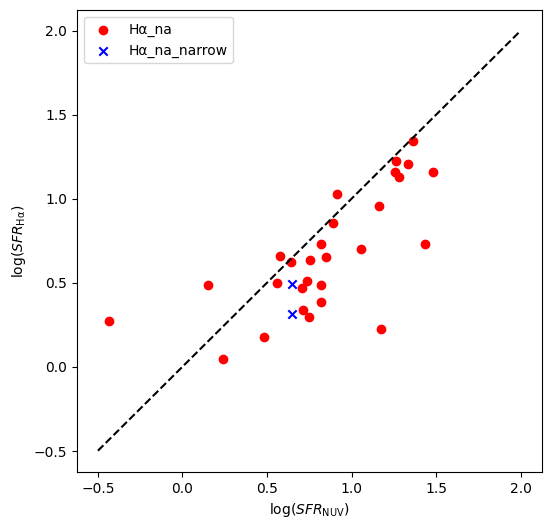

In [14]:
# change to good plt style
# plt.style.use('seaborn-v0_8-colorblind')

Ha_br_lumi = Ha_nrs['Ha_br_lum']
Ha_br_lumi_err = Ha_nrs['Ha_br_lum_err']
Ha_na_lumi = Ha_nrs['Ha_na_lum']
Ha_na_lumi_err = Ha_nrs['Ha_na_lum_err']
Ha1_na_lumi = Ha_nrs['Ha1_na_lum']
Ha1_na_lumi_err = Ha_nrs['Ha1_na_lum_err']

L_NUV = Ha_nrs['L_NUV']
L_FUV = Ha_nrs['L_FUV']

logsfr_NUV = np.log10(L_NUV) - 43.17
logsfr_FUV = np.log10(L_FUV) - 43.35
logsfr_Ha_nr = np.log10(Ha_na_lumi) - 41.27
logsfr_Ha_nr_err = Ha_na_lumi_err / Ha_na_lumi / np.log(10)
logsfr_Ha_br = np.log10(Ha_br_lumi) - 41.27
logsfr_Ha_br_err = Ha_br_lumi_err / Ha_br_lumi / np.log(10)
logsfr_Ha_all = np.log10(Ha_na_lumi + Ha_br_lumi) - 41.27
logsfr_Ha_all_err = np.sqrt(Ha_na_lumi_err**2 + Ha_br_lumi_err**2) / (Ha_na_lumi + Ha_br_lumi) / np.log(10)
logsfr_Ha1_na = np.log10(Ha1_na_lumi) - 41.27
logsfr_Ha1_na_err = Ha1_na_lumi_err / Ha1_na_lumi / np.log(10)

plt.figure(figsize=(6, 6))
# plt.errorbar(logsfr_NUV, logsfr_Ha_nr, xerr=None, yerr=Ha_na_lumi_err, fmt='o', label='Hα_br')
plt.scatter(logsfr_NUV[~narrow_Ha_mask], logsfr_Ha_nr[~narrow_Ha_mask], c='r', label='Hα_na')
# plt.scatter(logsfr_NUV[narrow_Ha_mask], logsfr_Ha_nr[narrow_Ha_mask], c='blue', label='Hα_na_narrow', marker='x')
plt.scatter(logsfr_NUV[narrow_Ha_mask], logsfr_Ha1_na[narrow_Ha_mask], c='blue', label='Hα_na_narrow', marker='x')

# plt.errorbar(logsfr_NUV[~narrow_Ha_mask], logsfr_Ha_br[~narrow_Ha_mask], xerr=None, yerr=Ha_br_lumi_err[~narrow_Ha_mask], fmt='o', label='Hα_br')
# plt.errorbar(logsfr_NUV[narrow_Ha_mask], logsfr_Ha_br[narrow_Ha_mask], xerr=None, yerr=Ha_br_lumi_err[narrow_Ha_mask], fmt='o', label='Hα_br_narrow')
# plt.scatter(logsfr_NUV[~narrow_Ha_mask], logsfr_Ha_br[~narrow_Ha_mask], c='g', label='Hα_br')
# plt.scatter(logsfr_NUV[narrow_Ha_mask], logsfr_Ha_br[narrow_Ha_mask], c='orange', label='Hα_br_narrow', marker='x')
# plt.scatter(logsfr_NUV, logsfr_Ha_br, c='b', label='Hα_br')
# plt.scatter(logsfr_NUV, logsfr_Ha_all, c='g', label='Hα_all')
# plt.scatter(logsfr_FUV, logsfr_Ha_nr, c='green', label='Hα_na')

x = np.linspace(-0.5, 2, 100)
plt.plot(x, x, 'k--')

plt.xlabel(r'$\log(SFR_{\rm NUV})$')
plt.ylabel(r'$\log(SFR_{\rm Hα})$')
plt.legend()    
# plt.loglog()